# Importing and Linking Drive

In [1]:
%pylab inline

import os
from google.colab import drive
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import pickle, gzip

from fastai.vision import *
from torch.nn.functional import *
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torchvision.transforms.functional as fn
import torchvision.datasets as datasets

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib
Mounted at /content/drive


# Model Creation and Training

Loading train set and test set

In [2]:
trainset = datasets.EMNIST(root='/content/drive/MyDrive/ITCS 5152/PG-13: Text to Speech/Stage 4/', train=True, download=True, split="letters", transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(-90, -90)), transforms.RandomHorizontalFlip(p=100), transforms.ToTensor()]))

In [3]:
testset = datasets.EMNIST(root='/content/drive/MyDrive/ITCS 5152/PG-13: Text to Speech/Stage 4/', train=False, download=True, split="letters", transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(-90, -90)), transforms.RandomHorizontalFlip(p=100), transforms.ToTensor()]))

Displaying Labels/Classes

In [4]:
labels = trainset.classes

In [5]:
labels.sort()
print(labels)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
img, label = next(iter(trainset))

Sample image and label

Label: w


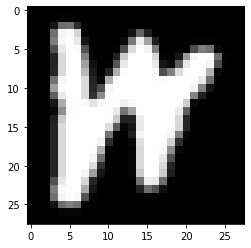

In [7]:
plt.imshow(img[0], cmap="gray")
print(f"Label: {labels[label]}")

LeNet-5 implementation

In [8]:
model = nn.Sequential(nn.Conv2d(1, 6, kernel_size = 5, padding=(2,2)), nn.Tanh(), 
                     nn.AvgPool2d(2), 
                     nn.Conv2d(6, 16 , kernel_size = 5), nn.Tanh(), 
                     nn.AvgPool2d(2), 
                     nn.Conv2d(16, 120, kernel_size=5), nn.Tanh(),
                     nn.Flatten(),
                     nn.Linear(120, 84), nn.Tanh(),
                     nn.Linear(84, 27))

In [9]:
import torch.nn.functional as F
from torch import nn
from torch import optim
from tqdm import tqdm

Training and Validating model

In [10]:
train_dl = DataLoader(trainset, batch_size=64, shuffle = True, num_workers = 4, drop_last = True)
valid_dl = DataLoader(testset, batch_size=64, shuffle = True, num_workers = 4, drop_last = True)

num_epochs = 5; lr = 1e-1; accuracies_cross_entropy = [] 

opt = optim.SGD(model.parameters(), lr=lr)
for i in range(num_epochs):
    for x, y in train_dl:
        yhat = model(x)
        loss = F.cross_entropy(yhat, y) 
        loss.backward() 
        opt.step(); opt.zero_grad();
    
  
    model.eval() 
    with torch.no_grad():
        x, y = next(iter(valid_dl)) 
        yhat = model(x)
        max_values, max_indices = torch.max(yhat, dim=1)
        accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
        accuracies_cross_entropy.append(accuracy)
        print('Epoch: ' + str(i+1) + ', training loss = ' + str(round(loss.item(), 3)) + \
              ', valid accuracy = ' + str(round(accuracy, 3)))

Epoch: 1, training loss = 0.365, valid accuracy = 0.875
Epoch: 2, training loss = 0.215, valid accuracy = 0.891
Epoch: 3, training loss = 0.165, valid accuracy = 0.953
Epoch: 4, training loss = 0.308, valid accuracy = 0.906
Epoch: 5, training loss = 0.274, valid accuracy = 0.891
Epoch: 6, training loss = 0.191, valid accuracy = 0.891
Epoch: 7, training loss = 0.069, valid accuracy = 0.938
Epoch: 8, training loss = 0.266, valid accuracy = 0.922
Epoch: 9, training loss = 0.207, valid accuracy = 0.922
Epoch: 10, training loss = 0.099, valid accuracy = 0.906


Testing model with random letters from the validation set

Accuracy: 90.625% 
Predicted Label: l 
Actual Label: l


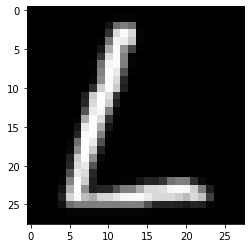

In [11]:
labels = trainset.classes

x, y = next(iter(valid_dl))
model.eval()
yhat = model(x)

max_values, max_indices = torch.max(yhat, dim=1)
accuracy = (max_indices.eq(y).sum().float()/len(y)).item()
pred_label = max_indices[0].numpy()
actual_label = y[0].numpy()

print(f"Accuracy: {round((accuracy * 100), 3)}% \nPredicted Label: {labels[pred_label]} \nActual Label: {labels[actual_label]}")
plt.imshow(x[0].numpy()[0], cmap="gray")

#Bounding Boxes

Extracting Letters from a word

In [12]:
def extract_letter(img):
  inv = 255 - img
  gray = cv2.cvtColor(inv, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
  contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = contours[0] if len(contours) == 2 else contours[1]
  contours.sort(key=lambda x:get_contour_precedence(x, thresh.shape[1]))

  index = 0
  for box in contours:
    x,y,w,h = cv2.boundingRect(box)
    bb = thresh[y:y + h, x:x + w]
    bb = cv2.resize(bb, (28, 28)) 
    cv2_imshow(bb)
    cv2.imwrite(f'/content/drive/MyDrive/ITCS 5152/PG-13: Text to Speech/Stage 4/Handwriting Test/temp/a/img_{index}.png', bb)
    index += 1

def get_contour_precedence(contour, cols):
    tolerance_factor = 30
    origin = cv2.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

In [22]:
test_path = '/content/drive/MyDrive/ITCS 5152/PG-13: Text to Speech/Stage 4/Handwriting Test/hello3.png'
test_img = cv2.imread(test_path)

extract_letter(test_img)

Pass letters into model

In [25]:
real_dataset = datasets.ImageFolder('/content/drive/MyDrive/ITCS 5152/PG-13: Text to Speech/Stage 4/Handwriting Test/', transform=transforms.Compose([
                             transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)]))
real_dl = DataLoader(real_dataset, batch_size=1, num_workers = 4, drop_last = True)
pred_labels = []
for x, y in real_dl:
  model.eval() 
  with torch.no_grad(): 
      yhat = model(x)
      max_values, max_indices = torch.max(yhat, dim=1)
      pred_labels.append(max_indices[0].numpy())

In [26]:
pred_labels
for x in pred_labels:
  print(f"Predicted Label: {labels[x]}")

Predicted Label: m
Predicted Label: l
Predicted Label: e
Predicted Label: l
Predicted Label: o


In [27]:
string = ''
for t in pred_labels:
  string += labels[t]
print(string)

mlelo


# Saving String as Audio File MP3

Convert string output and save it to MP3 File

In [ ]:
%pip install gTTS

In [29]:
from gtts import gTTS
language = 'en'
text_to_speech = gTTS(text=string, lang=language, slow=False)
text_to_speech.save("/content/drive/MyDrive/ITCS 5152/PG-13: Text to Speech/Stage 4/torch_output.mp3")